# Import libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

# Train, valid, test

Rename, put into folders separate and then create the batches

In [2]:
# rename the files for the trial 
# files in a directory or folder 
  
# importing os module 
import os 
  
# Function to rename multiple files 
def main(): 
  
    for count, filename in enumerate(os.listdir('../PlantVillageTest2/Pepper_bell_healthy')): 
        root = '../PlantVillageTest2/Pepper_bell_healthy'
        src = root +'/'+ filename 
        dst =root + "/healthy" + str(count) + ".jpg"
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 

# Driver Code 
if __name__ == '__main__':
    
#calling the function
    main()

In [3]:
# put the data in the appropiate folders
# unhealthy--- 996
# healthy---- 1477

os.chdir('../PlantVillageTest2')
if os.path.isdir('train/healthy') is False:
    os.makedirs('train/healthy')
    os.makedirs('train/unhealthy')
    os.makedirs('valid/healthy')
    os.makedirs('valid/unhealthy')
    os.makedirs('test/healthy')
    os.makedirs('test/unhealthy')

    for i in random.sample(glob.glob('Pepper_bell_healthy/healthy*'), 770):
        shutil.move(i, 'train/healthy')      
    for i in random.sample(glob.glob('Pepper_bell_Bacterial_spot/unhealthy*'), 770):
        shutil.move(i, 'train/unhealthy')
    for i in random.sample(glob.glob('Pepper_bell_healthy/healthy*'), 150):
        shutil.move(i, 'valid/healthy')        
    for i in random.sample(glob.glob('Pepper_bell_Bacterial_spot/unhealthy*'), 150):
        shutil.move(i, 'valid/unhealthy')
    for i in random.sample(glob.glob('Pepper_bell_healthy/healthy*'), 80):
        shutil.move(i, 'test/healthy')      
    for i in random.sample(glob.glob('Pepper_bell_Bacterial_spot/unhealthy*'), 80):
        shutil.move(i, 'test/unhealthy')

os.chdir('../../')

# when indicating the number that you want to substract since it is going to move the
# files, the number (sum of train, valid and test) needs to be at least the total

In [2]:
# we need the paths (relative wasn't working so absolute we go)

train_path = '/Users/mireiaguinovart/Documents/Ironhack/8-week/Project-Week-8-Final-Project/PlantVillageTest2/train'
valid_path = '/Users/mireiaguinovart/Documents/Ironhack/8-week/Project-Week-8-Final-Project/PlantVillageTest2/valid'
test_path = '/Users/mireiaguinovart/Documents/Ironhack/8-week/Project-Week-8-Final-Project/PlantVillageTest2/test'

In [5]:
# puting the data in the format of a Keras generator

'''Necessary to define the size of the images so they are all the same, it can be different
batch_size can be different too I guess'''

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=10, shuffle=False)

#shuffle = False for test since we need to access the unshuffled data and by default it gets shuffled

Found 1540 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


# Visualize data

In [6]:
# grab a single batch of images and labels

imgs, labels = next(train_batches)

In [7]:
# this function will plot images in the form of a grid with the 1 row and 10 columns where the images are placed
# from the tensor flow website
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

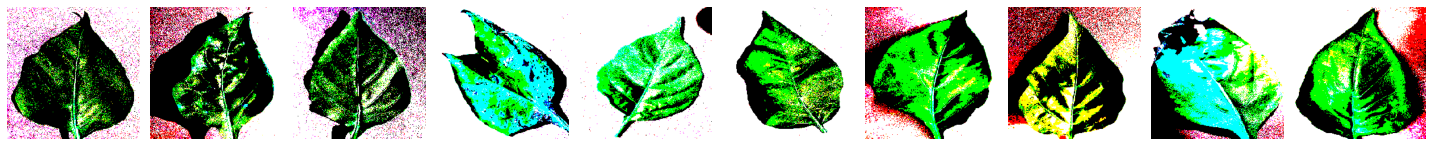

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [8]:
# it will print the BATCH
# the colours might look weird do to the preprocessing
plotImages(imgs)
print(labels)

# Model

In [9]:
# importing the model

vgg16_model = tf.keras.applications.vgg16.VGG16()

In [10]:
'''we have replicated the entire vgg16_model (excluding the output layer) 
to a new Sequential model (adding the layers one by one)'''

modelP2 = Sequential()
for layer in vgg16_model.layers[:-1]:
    modelP2.add(layer)

In [11]:
# freezing the weights of what was imported from VGG16

for layer in modelP2.layers:
    layer.trainable = False

In [12]:
# we add the output layer that will identify healthy and unhealthy

modelP2.add(Dense(units=2, activation='softmax'))

In [13]:
# omptimise the data

modelP2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model

In [21]:
# let's fit the model now 
#(same as before but with reduced epochs, we don't wanna crash the PC)

modelP2.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Train for 154 steps, validate for 30 steps
Epoch 1/5
154/154 - 2951s - loss: 0.0937 - accuracy: 0.9721 - val_loss: 0.1057 - val_accuracy: 0.9733
Epoch 2/5
154/154 - 1585s - loss: 0.0813 - accuracy: 0.9812 - val_loss: 0.0937 - val_accuracy: 0.9833
Epoch 3/5
154/154 - 3831s - loss: 0.0724 - accuracy: 0.9844 - val_loss: 0.0942 - val_accuracy: 0.9667
Epoch 4/5
154/154 - 681s - loss: 0.0667 - accuracy: 0.9864 - val_loss: 0.0822 - val_accuracy: 0.9833
Epoch 5/5
154/154 - 507s - loss: 0.0585 - accuracy: 0.9877 - val_loss: 0.0772 - val_accuracy: 0.9833


# Predictions + confusion matrix

In [22]:
predictions = modelP2.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [23]:
# directly from scikit-learn a function to plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
# so we know how to pass the classes later when we want to plot it

test_batches.class_indices

{'healthy': 0, 'unhealthy': 1}

In [6]:
train_batches.class_indices

{'healthy': 0, 'unhealthy': 1}

Confusion matrix, without normalization
[[78  2]
 [ 2 78]]


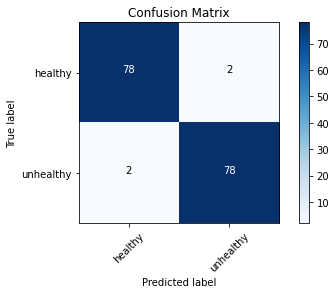

In [25]:
# we are using the confusion matrix creator function that we ran for the simpler model

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

# assigning the right labels and then plotting it

cm_plot_labels = ['healthy','unhealthy']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Save the model

In [19]:
from tensorflow.keras.models import Sequential, save_model, load_model

# Save the model
filepath = 'Project-Week-8-Final-Project/your-project/Pepper_complete_model'
save_model(modelP2, filepath)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Project-Week-8-Final-Project/your-project/Pepper_complete_model/assets
